In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import warnings

import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense

warnings.filterwarnings('ignore')

Using TensorFlow backend.


# Get the data

In [2]:
cwd = os.getcwd()
up1 = os.path.split(cwd)[0]
data = [os.path.join(up1,x) for x in os.listdir(up1) if x.endswith('.csv')][0]

# Define NN model

In [18]:
def baseline_model(X_train):
    model = Sequential()
    model.add(Dense(28, input_dim=56, activation='relu'))
    model.add(Dense(14, activation='relu'))
    model.add(Dense(7, activation='relu'))
    model.add(Dense(3, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['mse'])
    
    return model

# Setup the data for NN

In [19]:
df = pd.read_csv(data)
scaler = MinMaxScaler() # Scale the data using sklearn minmax scaler

labels = np.array(df['dry'])

features = df.drop(['dry','name'], axis = 1)
features = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)
features = np.array(features)

In [20]:
# Train / Test split
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 10)
    
# NN naming convention
X_train = np.array(train_features)
X_test = np.array(test_features)
y_train = np.array(train_labels)
y_test = np.array(test_labels)
    
# Fit model
model = baseline_model(X_train)
model.fit(X_train, y_train, epochs=15,verbose=1)
predictions = model.predict(X_test)

Epoch 1/15
27473/27473 [==============================] - 2s 58us/step - loss: 0.2109 - mean_squared_error: 0.0536
Epoch 2/15
27473/27473 [==============================] - 1s 44us/step - loss: 0.1981 - mean_squared_error: 0.0509
Epoch 3/15
27473/27473 [==============================] - 1s 44us/step - loss: 0.1957 - mean_squared_error: 0.0506
Epoch 4/15
27473/27473 [==============================] - 1s 44us/step - loss: 0.1951 - mean_squared_error: 0.0506
Epoch 5/15
27473/27473 [==============================] - 1s 42us/step - loss: 0.1945 - mean_squared_error: 0.0505
Epoch 6/15
27473/27473 [==============================] - 1s 43us/step - loss: 0.1944 - mean_squared_error: 0.0505
Epoch 7/15
27473/27473 [==============================] - 1s 43us/step - loss: 0.1940 - mean_squared_error: 0.0504
Epoch 8/15
27473/27473 [==============================] - 1s 43us/step - loss: 0.1941 - mean_squared_error: 0.0505
Epoch 9/15
27473/27473 [==============================] - 1s 43us/step - loss: 0

In [21]:
# Reshape 
predictions = predictions.reshape(predictions.shape[0])

# Take 
preds = []

for i in predictions:
    if i > np.percentile(predictions,95): # >95th percentile of probabilities = 1 (failure), else = 0 (non-failure)
        preds.append(1)
    else:
        preds.append(0)

In [22]:
mape = 100. * (np.abs((preds - y_test) / y_test))
np.mean(mape)

4.3896047171871588

In [23]:
accuracy = 100. - np.mean(mape)
accuracy

95.610395282812846

# Make a confusion matrix of the predictions 

In [24]:
cm = sklearn.metrics.confusion_matrix(y_test, preds)

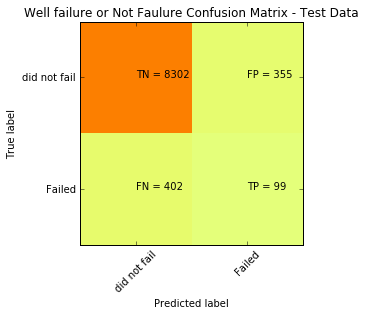

In [27]:
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['did not fail','Failed']
plt.title('Well failure or Not Faulure Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()